In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind

In [3]:
# 1. 데이터 불러오기
asthma_df = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx', index_col=0, parse_dates=True)
dust_df = pd.read_excel("pm10_top30_fixed.xlsx", index_col=0, parse_dates=True)


# 2. 공통 날짜 추출
common_index = dust_df.index.intersection(asthma_df.index)
dust_df = dust_df.loc[common_index].sort_index()
asthma_df = asthma_df.loc[common_index].sort_index()

# ✅ 3. 모든 값을 숫자로 변환하고 NaN 제거
dust_df = dust_df.apply(pd.to_numeric, errors='coerce')
asthma_df = asthma_df.apply(pd.to_numeric, errors='coerce')
dust_df = dust_df.dropna()
asthma_df = asthma_df.loc[dust_df.index]

# 3. 대도시 / 비대도시 분할
dust_major = dust_df.iloc[:, 0:8]
dust_minor = dust_df.iloc[:, 8:]

asthma_major = asthma_df.iloc[:, 0:8]
asthma_minor = asthma_df.iloc[:, 8:]

In [19]:
# print("대도시:", dust_major.shape)
# print("비대도시:", dust_minor.shape)

In [4]:
# 4. 상관계수 계산 함수
def get_corrs(df1, df2):
    return [pearsonr(df1.iloc[:, i], df2.iloc[:, i])[0] for i in range(df1.shape[1])]

major_corrs = get_corrs(dust_major, asthma_major)
minor_corrs = get_corrs(dust_minor, asthma_minor)


In [6]:
# 평균 비교 및 t-검정
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(major_corrs, minor_corrs, equal_var=False)

print("대도시 평균 상관계수:", np.mean(major_corrs))
print("비대도시 평균 상관계수:", np.mean(minor_corrs))
print("T-검정 결과: t =", t_stat, ", p =", p_value)

if p_value < 0.05:
    print("대도시와 비대도시 간 상관관계에 유의미한 차이가 존재.")
else:
    print("대도시와 비대도시 간 상관관계에 유의미한 차이 없음.")

대도시 평균 상관계수: 0.5187115672146455
비대도시 평균 상관계수: 0.49583917994675364
T-검정 결과: t = 0.7891484868216943 , p = 0.4387409976499511
대도시와 비대도시 간 상관관계에 유의미한 차이 없음.


대도시 평균 상관계수: 0.519
비대도시 평균 상관계수: 0.496
t = 0.594, p = 0.5566


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_1612\1555959275.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="coolwarm")


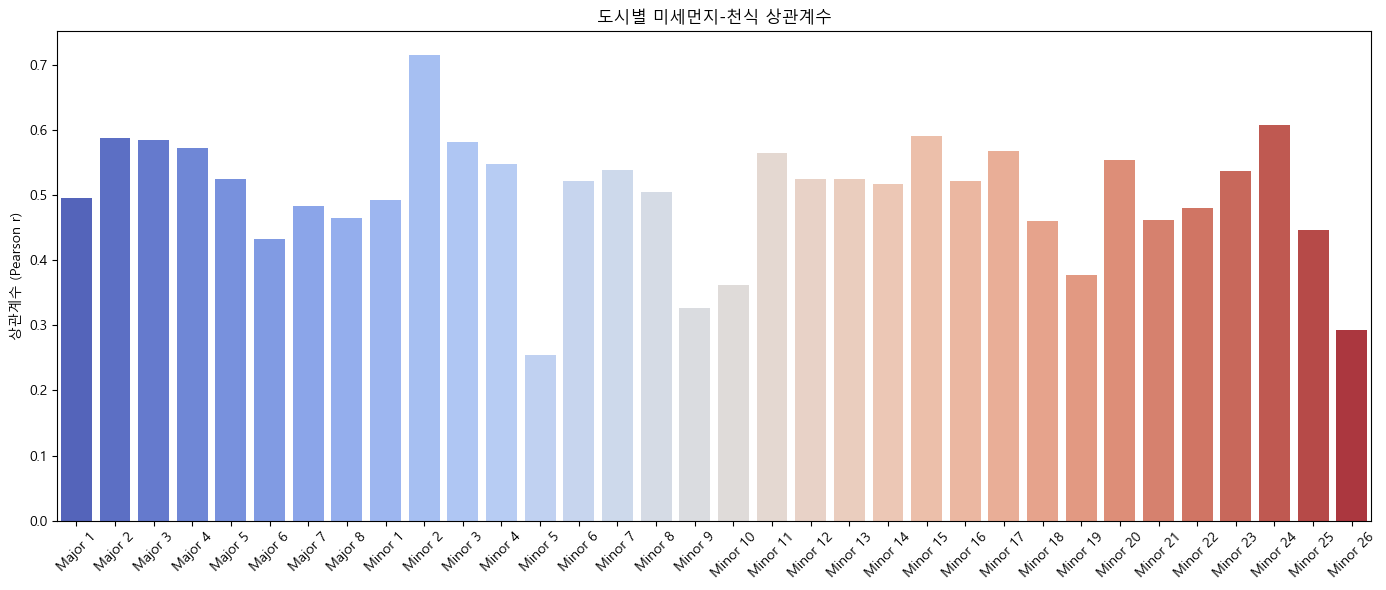

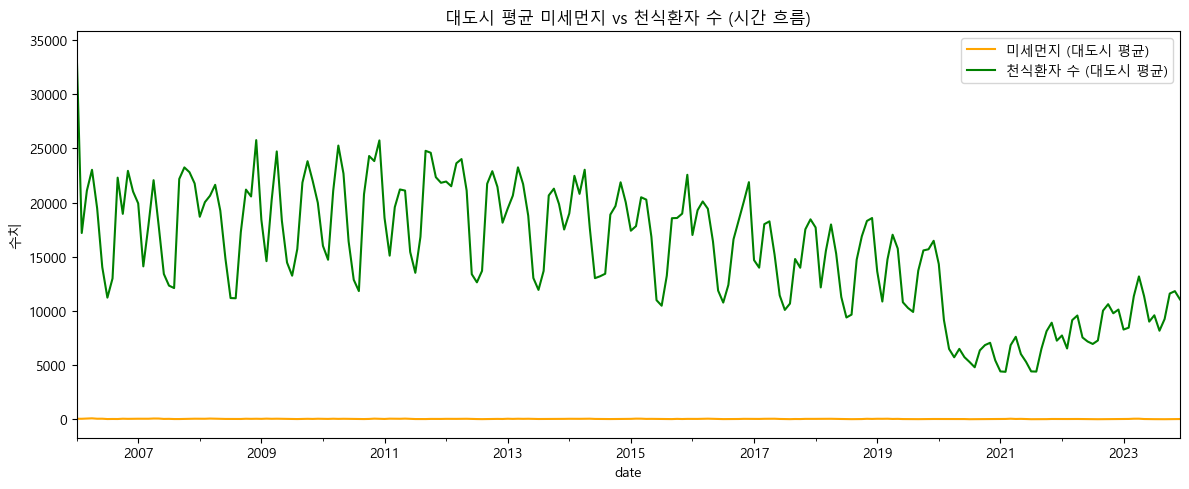

ValueError: All arrays must be of the same length

In [62]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'NanumGothic', 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 데이터 불러오기
asthma_df = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx', index_col=0, parse_dates=True)
dust_df = pd.read_excel("pm10_top30_fixed.xlsx", index_col=0, parse_dates=True)

# 2. 날짜 동기화
common_index = dust_df.index.intersection(asthma_df.index)
dust_df = dust_df.loc[common_index].sort_index()
asthma_df = asthma_df.loc[common_index].sort_index()

# 3. 숫자 변환 및 결측치 처리
dust_df = dust_df.apply(pd.to_numeric, errors='coerce')
asthma_df = asthma_df.apply(pd.to_numeric, errors='coerce')

dust_df = dust_df.interpolate().dropna()
asthma_df = asthma_df.loc[dust_df.index]

# 4. 대도시 vs 비대도시 분할
dust_major = dust_df.iloc[:, 0:8]
dust_minor = dust_df.iloc[:, 8:]
asthma_major = asthma_df.iloc[:, 0:8]
asthma_minor = asthma_df.iloc[:, 8:]

# 5. 상관계수 계산 함수
def get_corrs(df1, df2):
    corrs = []
    for i in range(df1.shape[1]):
        x = df1.iloc[:, i]
        y = df2.iloc[:, i]
        valid = x.notna() & y.notna()
        if valid.sum() >= 2:
            corr, _ = pearsonr(x[valid], y[valid])
            corrs.append(corr)
        else:
            corrs.append(np.nan)
    return corrs

# 6. 상관계수 추출
major_corrs = get_corrs(dust_major, asthma_major)
minor_corrs = get_corrs(dust_minor, asthma_minor)

# 7. 평균 상관계수 비교
print(f"대도시 평균 상관계수: {np.nanmean(major_corrs):.3f}")
print(f"비대도시 평균 상관계수: {np.nanmean(minor_corrs):.3f}")

# 8. 통계 검정 (독립표본 t검정)
t_stat, p_val = ttest_ind(major_corrs, minor_corrs, nan_policy='omit')
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

# --------------------------------------
# 📊 시각화 1: 도시별 상관계수 막대그래프
plt.figure(figsize=(14, 6))
labels = [f"Major {i+1}" for i in range(len(major_corrs))] + [f"Minor {i+1}" for i in range(len(minor_corrs))]
values = major_corrs + minor_corrs
sns.barplot(x=labels, y=values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("도시별 미세먼지-천식 상관계수")
plt.ylabel("상관계수 (Pearson r)")
plt.tight_layout()
plt.show()

# 📈 시각화 2: 대도시 평균 변화 시계열
plt.figure(figsize=(12, 5))
dust_major.mean(axis=1).plot(label="미세먼지 (대도시 평균)", color='orange')
asthma_major.mean(axis=1).plot(label="천식환자 수 (대도시 평균)", color='green')
plt.legend()
plt.title("대도시 평균 미세먼지 vs 천식환자 수 (시간 흐름)")
plt.ylabel("수치")
plt.tight_layout()
plt.show()

# 🔥 시각화 3: 상관계수 히트맵
combined_corr_df = pd.DataFrame({
    '대도시': major_corrs,
    '비대도시': minor_corrs
})
sns.heatmap(combined_corr_df.T, annot=True, cmap='coolwarm', center=0)
plt.title("도시 그룹별 상관계수 히트맵")
plt.show()

대도시 평균 상관계수: 0.519
비대도시 평균 상관계수: 0.496
t = 0.594, p = 0.5566


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_1612\316564947.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="coolwarm")


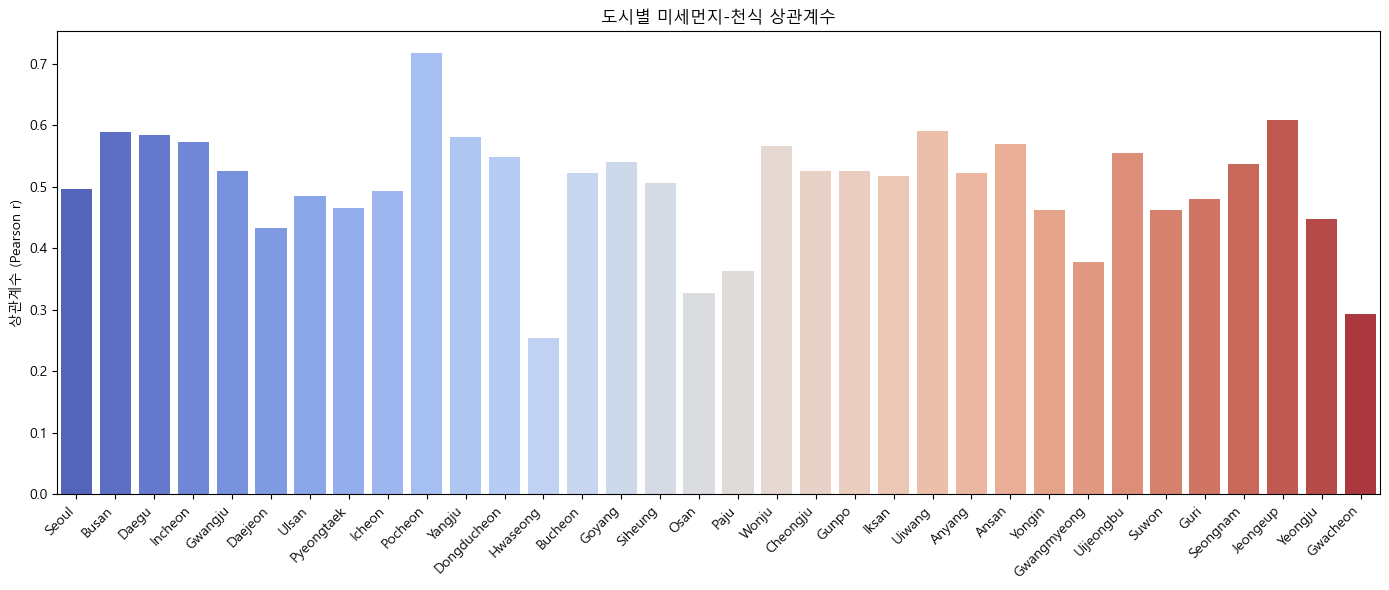

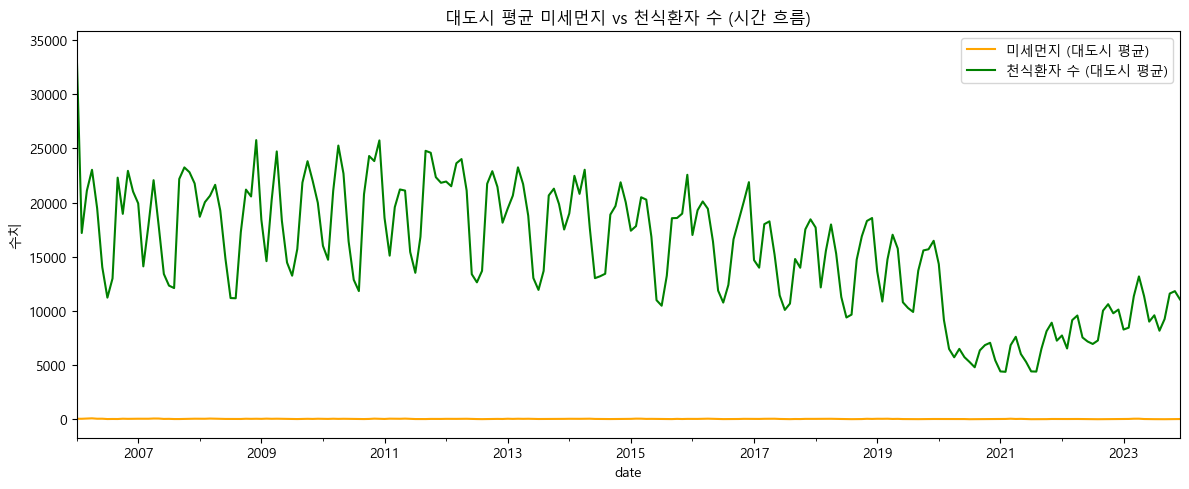

ValueError: Length of values (8) does not match length of index (34)

In [63]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'NanumGothic', 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 데이터 불러오기
asthma_df = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx', index_col=0, parse_dates=True)
dust_df = pd.read_excel("pm10_top30_fixed.xlsx", index_col=0, parse_dates=True)

# 2. 날짜 동기화
common_index = dust_df.index.intersection(asthma_df.index)
dust_df = dust_df.loc[common_index].sort_index()
asthma_df = asthma_df.loc[common_index].sort_index()

# 3. 숫자 변환 및 결측치 처리
dust_df = dust_df.apply(pd.to_numeric, errors='coerce')
asthma_df = asthma_df.apply(pd.to_numeric, errors='coerce')

dust_df = dust_df.interpolate().dropna()
asthma_df = asthma_df.loc[dust_df.index]

# 4. 대도시 vs 비대도시 분할
dust_major = dust_df.iloc[:, 0:8]
dust_minor = dust_df.iloc[:, 8:]
asthma_major = asthma_df.iloc[:, 0:8]
asthma_minor = asthma_df.iloc[:, 8:]

# 5. 상관계수 계산 함수
def get_corrs(df1, df2):
    corrs = []
    for i in range(df1.shape[1]):
        x = df1.iloc[:, i]
        y = df2.iloc[:, i]
        valid = x.notna() & y.notna()
        if valid.sum() >= 2:
            corr, _ = pearsonr(x[valid], y[valid])
            corrs.append(corr)
        else:
            corrs.append(np.nan)
    return corrs

# 6. 상관계수 추출
major_corrs = get_corrs(dust_major, asthma_major)
minor_corrs = get_corrs(dust_minor, asthma_minor)

# 7. 평균 상관계수 비교
print(f"대도시 평균 상관계수: {np.nanmean(major_corrs):.3f}")
print(f"비대도시 평균 상관계수: {np.nanmean(minor_corrs):.3f}")

# 8. 통계 검정 (독립표본 t검정)
t_stat, p_val = ttest_ind(major_corrs, minor_corrs, nan_policy='omit')
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

# --------------------------------------
# 📊 시각화 1: 도시별 상관계수 막대그래프 (도시 이름 라벨)
plt.figure(figsize=(14, 6))
labels = list(dust_major.columns) + list(dust_minor.columns)
values = major_corrs + minor_corrs
sns.barplot(x=labels, y=values, palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title("도시별 미세먼지-천식 상관계수")
plt.ylabel("상관계수 (Pearson r)")
plt.tight_layout()
plt.show()

# 📈 시각화 2: 대도시 평균 변화 시계열
plt.figure(figsize=(12, 5))
dust_major.mean(axis=1).plot(label="미세먼지 (대도시 평균)", color='orange')
asthma_major.mean(axis=1).plot(label="천식환자 수 (대도시 평균)", color='green')
plt.legend()
plt.title("대도시 평균 미세먼지 vs 천식환자 수 (시간 흐름)")
plt.ylabel("수치")
plt.tight_layout()
plt.show()

# 🔥 시각화 3: 상관계수 히트맵
combined_corr_df = pd.DataFrame({
    '대도시': major_corrs,
    '비대도시': minor_corrs
}, index=list(dust_major.columns) + list(dust_minor.columns))
sns.heatmap(combined_corr_df.T, annot=True, cmap='coolwarm', center=0)
plt.title("도시 그룹별 상관계수 히트맵")
plt.show()


In [64]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 불러오기
asthma_df = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx', index_col=0, parse_dates=True)
dust_df = pd.read_excel("pm10_top30_fixed.xlsx", index_col=0, parse_dates=True)

# 2. 날짜 동기화
common_index = dust_df.index.intersection(asthma_df.index)
dust_df = dust_df.loc[common_index].sort_index()
asthma_df = asthma_df.loc[common_index].sort_index()

# 3. 숫자 변환 및 결측치 처리
dust_df = dust_df.apply(pd.to_numeric, errors='coerce')
asthma_df = asthma_df.apply(pd.to_numeric, errors='coerce')

dust_df = dust_df.interpolate().dropna()
asthma_df = asthma_df.loc[dust_df.index]


In [65]:
print(dust_df.columns)
print(asthma_df.columns)

Index(['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon', 'Ulsan',
       'Pyeongtaek', 'Icheon', 'Pocheon', 'Yangju', 'Dongducheon', 'Hwaseong',
       'Bucheon', 'Goyang', 'Siheung', 'Osan', 'Paju', 'Wonju', 'Cheongju',
       'Gunpo', 'Iksan', 'Uiwang', 'Anyang', 'Ansan', 'Yongin', 'Gwangmyeong',
       'Uijeongbu', 'Suwon', 'Guri', 'Seongnam', 'Jeongeup', 'Yeongju',
       'Gwacheon'],
      dtype='object')
Index(['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon', 'Ulsan',
       'Pyeongtaek', 'Icheon', 'Pocheon', 'Yangju', 'Dongducheon', 'Hwaseong',
       'Bucheon', 'Goyang', 'Siheung', 'Osan', 'Paju', 'Wonju', 'Cheongju',
       'Gunpo', 'Iksan', 'Uiwang', 'Anyang', 'Ansan', 'Yongin', 'Gwangmyeong',
       'Uijeongbu', 'Suwon', 'Guri', 'Seongnam', 'Jeongeup', 'Yeongju',
       'Gwacheon'],
      dtype='object')


김포 상관계수 (Pearson r): -0.025
하남 상관계수 (Pearson r): 0.060


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_1612\2692399793.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(corrs.keys()), y=list(corrs.values()), palette="coolwarm")


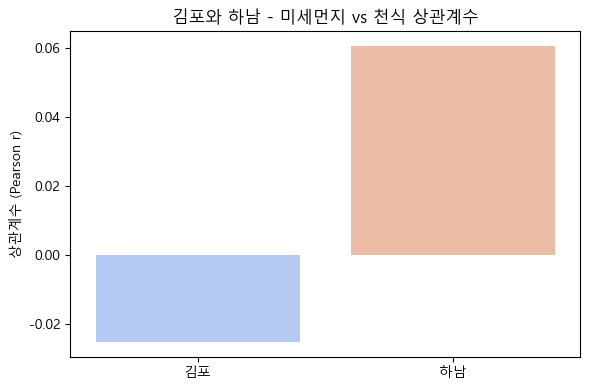

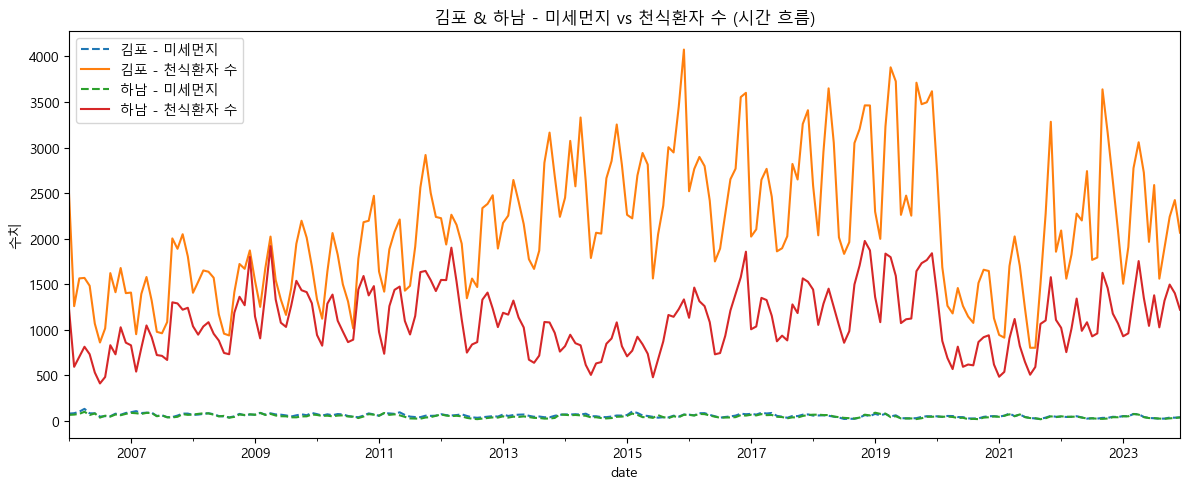

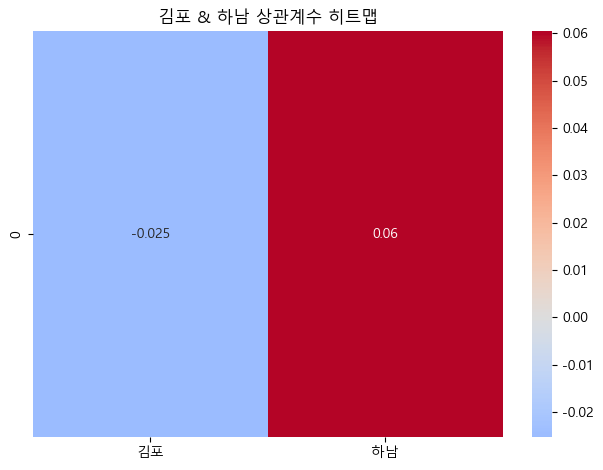

In [34]:
# ✅ 4. 김포와 하남만 선택
target_cities = ['김포', '하남']
dust_selected = dust_df[target_cities]
asthma_selected = asthma_df[target_cities]

# ✅ 5. 상관계수 계산
corrs = {}
for city in target_cities:
    x = dust_selected[city]
    y = asthma_selected[city]
    valid = x.notna() & y.notna()
    if valid.sum() >= 2:
        corr, _ = pearsonr(x[valid], y[valid])
        corrs[city] = corr
    else:
        corrs[city] = np.nan

# ✅ 6. 출력
for city, corr in corrs.items():
    print(f"{city} 상관계수 (Pearson r): {corr:.3f}")

# 📊 시각화 1: 도시별 상관계수 막대그래프
plt.figure(figsize=(6, 4))
sns.barplot(x=list(corrs.keys()), y=list(corrs.values()), palette="coolwarm")
plt.title("김포와 하남 - 미세먼지 vs 천식 상관계수")
plt.ylabel("상관계수 (Pearson r)")
plt.tight_layout()
plt.show()

# 📈 시각화 2: 시계열 비교
plt.figure(figsize=(12, 5))
for city in target_cities:
    dust_selected[city].plot(label=f"{city} - 미세먼지", linestyle='--')
    asthma_selected[city].plot(label=f"{city} - 천식환자 수")
plt.legend()
plt.title("김포 & 하남 - 미세먼지 vs 천식환자 수 (시간 흐름)")
plt.ylabel("수치")
plt.tight_layout()
plt.show()

# 🔥 시각화 3: 히트맵
corr_df = pd.DataFrame([corrs])
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("김포 & 하남 상관계수 히트맵")
plt.tight_layout()
plt.show()